In [2]:
import numpy as np
import matplotlib.pyplot as plt
from getdist import plots, MCSamples

In [ ]:
samples_4 = np.load('./bpl_wfld_4.npz')
samples_5 = np.load('./bpl_wfld_5.npz')

{'w': [0.6, 0.9], 'log10_f_rh': [-5.5, -4.5], 'x_0': [-5.0, -1.30103], 'x_1': [-5.0, -1.30103], 'y_0': [-6, -2], 'y_1': [-6, -2], 'y_2': [-6, -2], 'y_3': [-6, -2]}
Removed no burn in


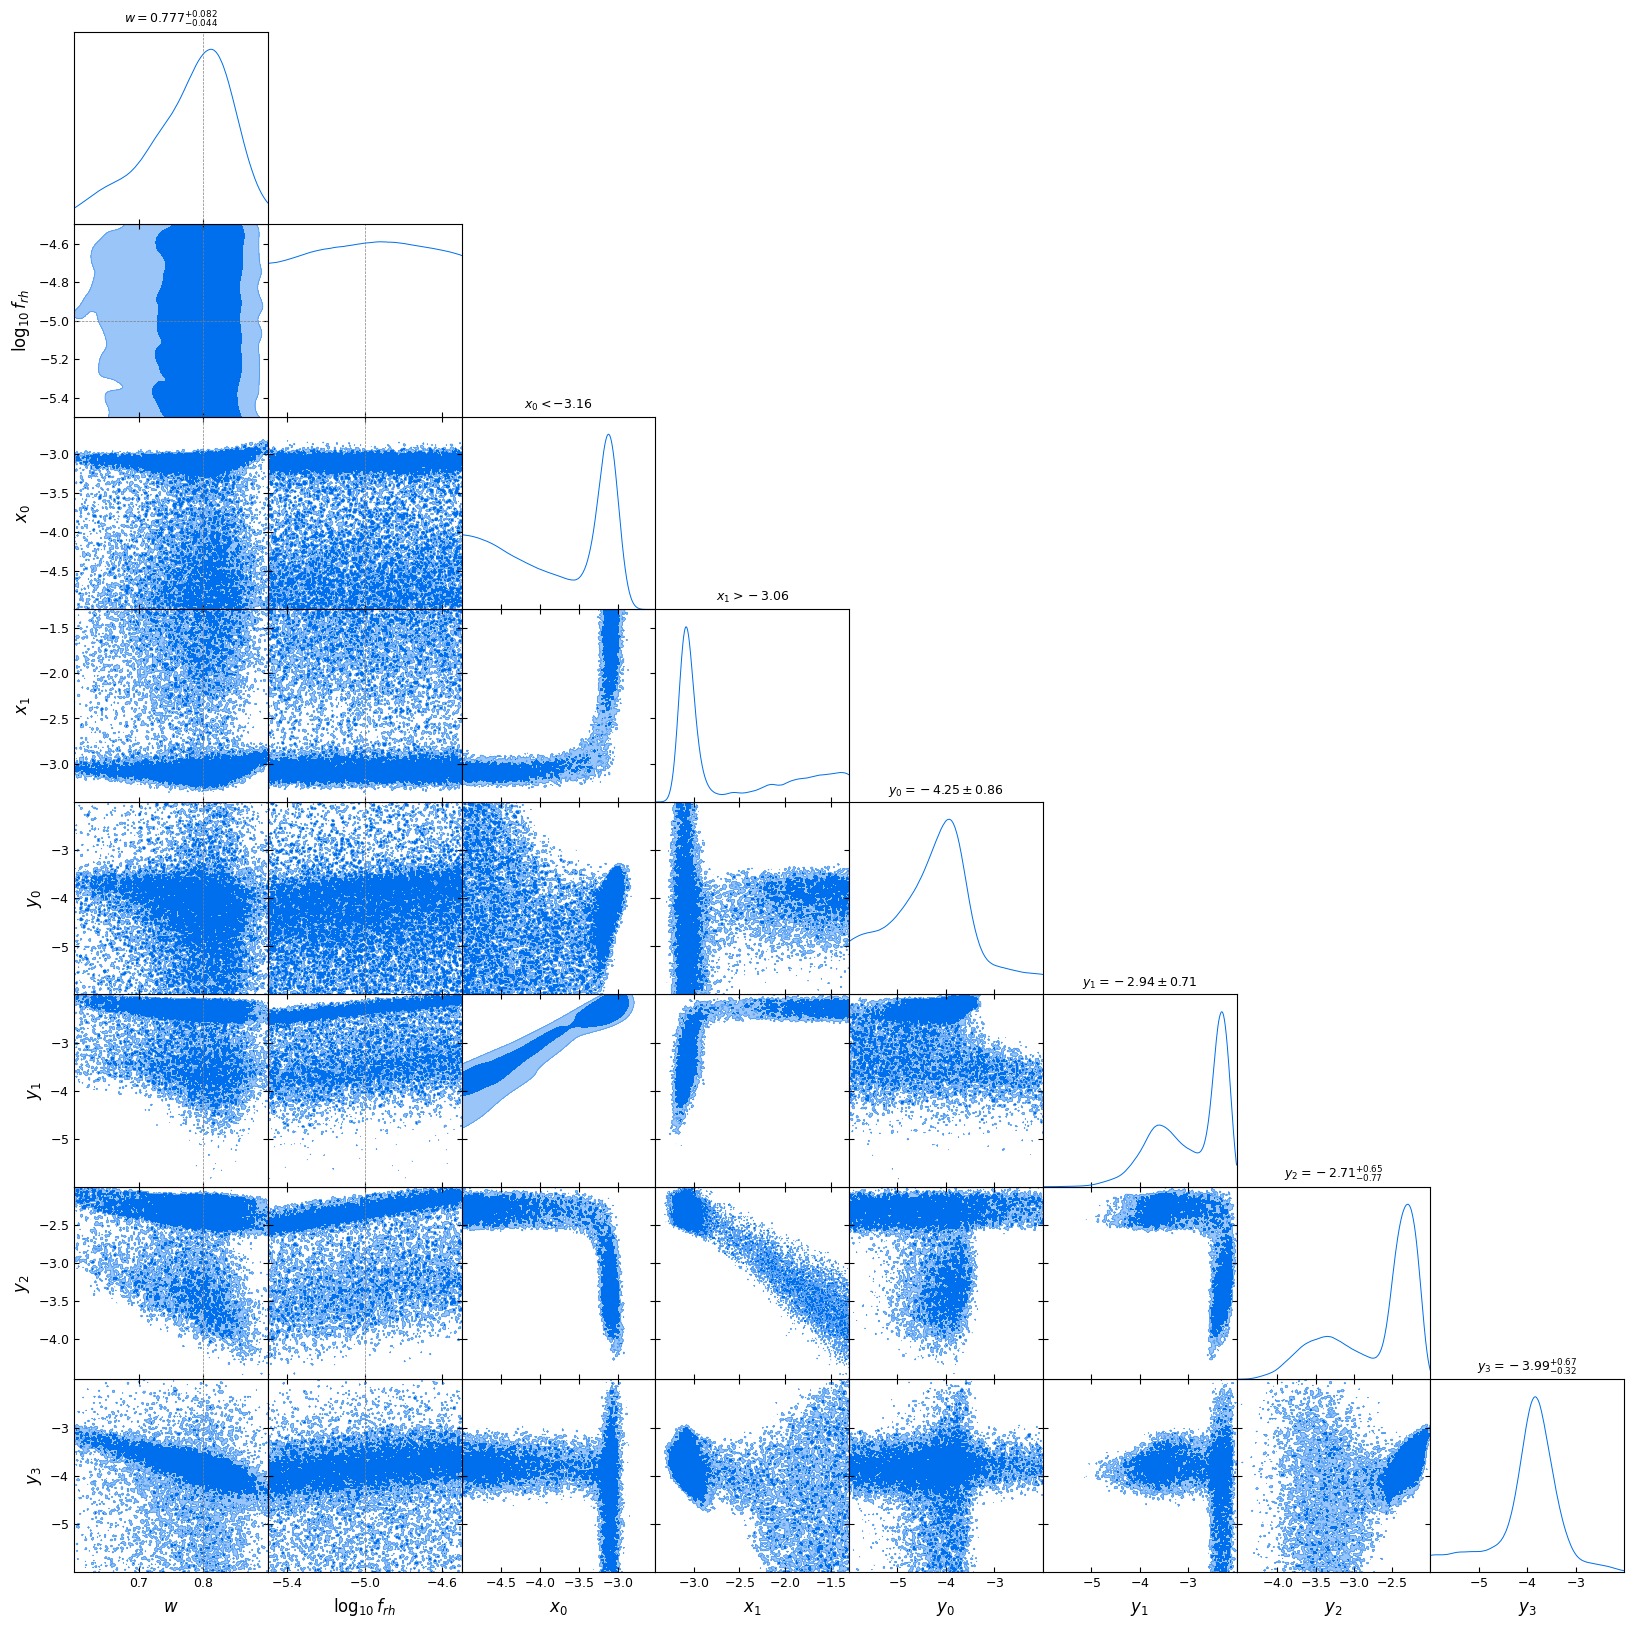

In [19]:
num_nodes = 4
names = ['w','log10_f_rh']
labels = ['w','\\log_{10} f_{rh}']
names+= [f'x_{i}' for i in range(num_nodes-2)]
labels+= [f'x_{i}' for i in range(num_nodes-2)]
names+= [f'y_{i}' for i in range(num_nodes)]
labels+= [f'y_{i}' for i in range(num_nodes)]
bounds = [[0.6,0.9],[-5.5,-4.5]]
bounds+= [[-5.0, -1.30103] for i in range(num_nodes-2)]
bounds+=[[-6,-2] for i in range(num_nodes)]
ranges = dict(zip(names,bounds))
print(ranges)
gd_sample_4 = MCSamples(samples=samples_4['samples'], names=names, labels=labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=2.5)
markers = {'w': 0.8, 'log10_f_rh': -5.0}
g.triangle_plot(gd_sample_4,filled=True,markers=markers,title_limit=1)